# $\rho'$ analysis notes

## GIRD Selection criteria:

These criteria were applied on the selection stage(GRID):

Events:

    * >= 4 tracks
    
Tracks:

    * Has Point On inner OR outer ITS Layer
    * Not ITS SA
    * |dca1| < 3 && |dca0| < 3;

### Data info

In [1]:
from modules.FourTrackEvents import *

ccup9_2015_file = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4Prongs2015o.root'

tree_name = '4Prongs/events'
# dfs.loc[0] # get dataframe part with entry = 0

branches = ['T_Px', 'T_Py', 'T_Pz',  'T_Q', 'T_NumberOfSigmaTPCPion', 'T_TPCRefit', 'T_TPCNCls', 'T_Phi', 'T_Eta', 'T_HasPointOnITSLayer0','T_HasPointOnITSLayer1', 'T_ITSModuleInner', 'T_ITSModuleOuter']

ft = FourTrackEvents(ccup9_2015_file,tree_name,branches)

ft.orig_events.show()

print()
print('Tree name:', ft.orig_events.name)
print('Tree title:', ft.orig_events.title)
print('Events number:', ft.orig_tracks.reset_index().entry.max())
print('Tracks number', len(ft.orig_tracks))


ITSSensorNums = events.arrays(filter_name=['T_ITSSensorNum'], library='pd')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
RunNum               | int32_t                  | AsDtype('>i4')
PeriodNumber         | uint32_t                 | AsDtype('>u4')
OrbitNumber          | uint32_t                 | AsDtype('>u4')
BunchCrossNumber     | uint16_t                 | AsDtype('>u2')
Mass                 | float                    | AsDtype('>f4')
Pt                   | float                    | AsDtype('>f4')
Q                    | int16_t                  | AsDtype('>i2')
Rapidity             | float                    | AsDtype('>f4')
Phi                  | float                    | AsDtype('>f4')
ZNAenergy            | float                    | AsDtype('>f4')
ZNCenergy            | float                    | AsDtype('>f4')
ZPAenergy            | float                    | AsDtype('>f4')
ZPCenergy            | float                    | AsDtype(

NameError: name 'events' is not defined

## Analysis criteria

Let's take from input date only events with 4 tracks and zero total charge.
Also prepare mask for tracks that satisfy standatd criteria contains further conditions for the TPC:

* |NumberOfSigmaTPCPion| < 3
* Number of TPC Clusters > 50
* TPCRefit


## Low energy tracks and TPC

There is an idea about that tracks with small energies (low pt) not able to reach TPC.
We can try to estimate influence of TPC criteria to the statistics.

Let's see what happend in case of we will plot pt for any combination of TPC tracks:

### Event with std criteria

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|+|+|+|

### Let's start to take also such combinations to the sample:

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|+|+|-|

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|+|-|-|

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|-|-|-|

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|-|-|-|-|

We can see statistics gain ration equal 2.5 between std criteria and total combinations:


In [168]:
from modules.physics import kinematics
from modules.physics.analysis.ITSvsTPC_events import *
from matplotlib.patches import Rectangle 

%matplotlib widget

tpcimpPt = []
colors = ['red', 'green', 'yellow', 'orange', 'black']
labels = ['ITS & (>= 0TPC)', 'ITS & (>= 1TPC)',
          'ITS & (>= 2TPC)', 'ITS & (>= 3TPC)', 'ITS & ( =  4TPC)']
for i in range(5):
    tmpPt = kinematics.pt_events(ft.GetTracksWithNTPC(ft.four_tracks_zq,i))
    tpcimpPt.append(tmpPt)

ShowComparisonSame('', tpcimpPt, r'$p_t \pi^+\pi^-\pi^+\pi^-$,GeV',
                   labels, colors, nBins=100, ranges=(0, 2),showPatch=True)

KeyboardInterrupt: 

As we can see here pt for $Q \neq 0$ contains only background events:

In [6]:
from matplotlib.patches import Rectangle 
from modules.physics import kinematics

%matplotlib widget

plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

fig.suptitle(f'$p_t$ of events', fontsize=32)
b = 100
r = 0,2
counts,bin_edges = np.histogram(kinematics.pt_events(ft.GetTracksWithNTPC(ft.four_tracks_zq)), bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt((counts - np.average(counts))**2/len(counts))
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', label=r'$Q=0$', color=colors[0])

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$p_t, GeV$')
ax.set_ylabel(f'#events / {val}MeV')
ax.add_patch(Rectangle((0, 0.15), 0.15, 900, fc='lightgrey', alpha=0.4))
ax.text(0.15,0,"0.15", size=20)
counts,bin_edges = np.histogram(kinematics.pt_events(ft.GetTracksWithNTPC(ft.four_tracks_nzq)), bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt((counts - np.average(counts))**2/len(counts))
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', label=r'$Q\neq0$', color=colors[2])
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now  let's try to see what tracks we lost from signal area and what contribution they have:

TPC and ITS has different coverage for polar angle:

![img1](https://camo.githubusercontent.com/9a7ab40d0f74a866a7095986644134a0f72cc58b/68747470733a2f2f70702e757365726170692e636f6d2f633835323231362f763835323231363738332f3131396137332f304f76685f6c544b4e7a552e6a7067)

Perhaps we have tracks that not only can't reach TPC, but also has $\theta$ values that TPC doesn't cover.

Below we can see polar angle distribution for tracks that covers three cases:

1. All tracks from events were reconstructed by ITS and TPC
2. Only ITS tracks from events with only part TPC tracks. Here tracks that not reconstructed by TPC
3. All tracks from events were reconstructed by ITS or TPC

We can see small gaps with for the second case, that allow to speak about correctness of the suggestion, but anyway low energy of tracks is the main reason why TPC can't reconstructed tracks.  

In [7]:
ShowComparison('$\\theta$',[AllTPCTracksTheta, ITSDiffTPCTracksTheta, TotalLowPtTheta], '$^\\circ$', ['ITS&&TPC', 'OnlyITSFromNTPCEvents', 'ITS||TPC'], None, nBins=80, ranges=(25,150))

NameError: name 'ShowComparison' is not defined

## Mass
Let's see on the mass distribution of the events


In [45]:
from modules.physics import kinematics
from modules.physics.analysis.ITSvsTPC_events import *

%matplotlib widget

tpcimpMass = []
colors = ['red', 'orange', 'black']
labels = ['ITS & (>= 2TPC)', 'ITS & (>= 3TPC)', 'ITS & ( =  4TPC)']

for i in range(2,5):
    tpcimpMass.append(kinematics.mass_events(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_zq,i))))

ShowComparisonSame('4track events Mass', tpcimpMass, '$Mass, GeV$',
                   labels, colors, nBins=100, ranges=(0.5, 3.5))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
tpcimpMass[1]

entry
50        1.353709
73        1.440432
217       1.435406
225       1.688103
244       2.136009
            ...   
114503    1.526976
114516    1.220580
114525    1.827874
114542    1.651049
114572    1.554796
Length: 3059, dtype: float32

In [17]:
from modules.data.selection import Get4TracksEvents
from modules.physics.analysis.mass import *


%matplotlib widget

plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()

fig.suptitle(f'Масса $\pi^+\pi^-\pi^+\pi^-$', fontsize=32)
b = 100
r = 0.5,3.5
counts,bin_edges = np.histogram(tpcimpMass[1], bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt((counts - np.average(counts))**2/len(counts))
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', label='Q = 0', color=colors[0])

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$Mass, GeV$')
ax.set_ylabel(f'#events / {val}MeV')

counts,bin_edges = np.histogram(kinematics.mass_events(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_nzq))), bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt((counts - np.average(counts))**2/len(counts))
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', color=colors[1], label=r"$Q\neq0$")

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$Mass, GeV$')
ax.set_ylabel(f'#events / {val}MeV')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
from modules.data.selection import Get4TracksEvents
from modules.physics.analysis.mass import GetEventMass


%matplotlib widget

plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()

fig.suptitle(f'4 tracks mass', fontsize=32)
b = 100
r = 0.5,3.5


counts,bin_edges = np.histogram(kinematics.mass_events(ft.GetTracksWithNTPC(ft.four_tracks_nzq)), bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt((counts - np.average(counts))**2/len(counts))
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', color=colors[1], label=r"$Q\neq0$")

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$Mass, GeV$')
ax.set_ylabel(f'#events / {val}MeV')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

+### Pions subsystems

In our process 4 pions were producted. The most probably intermediate state including two pions and $\rho$ i.e.
$$\rho' \rightarrow \rho \ \pi^+ \pi^- \rightarrow \pi^+ \pi^- \pi^+ \pi^-$$ 

We can see this on distribution of mass that can be obtained as all combinations of pairs from intial four tracks, i.e. only four pairs:

![img](https://camo.githubusercontent.com/53a52e2a6d4ae7112d74f4073c979a51166170d8/68747470733a2f2f70702e757365726170692e636f6d2f633835333632342f763835333632343436372f34383466332f5431375a754b597062526f2e6a7067)

Here we can plot two distirbutions:

1. Make all possible(4) combinations of pairs. Then take lightest and pair that belong to one combination with that. Plot masses of these two pairs.
2. Plot masses of masses from possible combinations.

In [2]:
from modules.physics.analysis import pairs

%matplotlib widget
# ShowMassComaprison(LiteHeavyRecoil, 'Lightest and Recoil Pairs')
LiteHeavyRecoil, LiteHeavyTotal = pairs.GetPairs(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_zq,2)))
pairs.ShowMassComaprison(LiteHeavyTotal, r'Массы $\rho^0 \rightarrow \pi^+\pi^-$   и    $\pi^+\pi^-$')

NameError: name 'ft' is not defined

As we can see above, for second case (all possible pairs) we've got stronger signal in comparison with light-recoil pair as it made in [STAR work](http://arxiv.org/abs/0912.0604v2). Let's build 2d distirbuition and marginals component separately:

In [31]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np



plt.style.use(hep.style.ROOT)

fig = plt.figure(figsize=(15, 7))

gs = GridSpec(4,4,wspace=0.1,hspace=0.1)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.hist2d(LiteHeavyTotal.Recoil, LiteHeavyTotal.Lite, bins=(50, 50), range=[(0, 2), (0, 2)], cmap=plt.cm.jet)
_ = ax_marg_y.hist(LiteHeavyTotal.Lite, bins=100, range=(0, 2), histtype='step', color='blue', linewidth=2, label='lite pair',orientation="horizontal")
_ = ax_marg_x.hist(LiteHeavyTotal.Recoil, bins=100, range=(0, 2), histtype='step', color='red', linewidth=2, label='rest pair')


ax_joint.set_ylabel('Lightest pair Mass, GeV')
ax_joint.set_xlabel('Recoiling pair Mass, GeV')

# ax_marg_y.set_xlabel('$Mass, GeV$')
ax_marg_y.set_xlabel('# events')
ax_marg_x.yaxis.set_label_position("right")
ax_marg_x.xaxis.set_ticks([])
ax_marg_x.xaxis.set_ticks_position('none')
ax_marg_y.yaxis.set_ticks_position('none')
ax_marg_y.yaxis.set_ticks([])

# ax_marg_x.set_xlabel('$Mass, GeV$')
ax_marg_x.set_ylabel('# events')
ax_marg_y.xaxis.set_label_position("top")
ax_marg_x
ax_joint.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


In [13]:
%matplotlib widget


plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()

counts1, bins1  = np.histogram(LiteHeavyRecoil.Recoil, bins=100, range=(0,2))
counts2, bins2  = np.histogram(LiteHeavyTotal.Recoil, bins=100, range=(0,2))

_ = ax.hist(counts1/counts2,bins=bins1, histtype='step', color='black', linewidth=2)


plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()

counts1, bins1  = np.histogram(LiteHeavyRecoil.Lite, bins=100, range=(0,2))
counts2, bins2  = np.histogram(LiteHeavyTotal.Lite, bins=100, range=(0,2))

_ = ax.hist(counts1/counts2,bins=bins1, histtype='step', color='black', linewidth=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## $\eta$ distribution for pairs

In [14]:
from modules.physics.analysis.mass import LiteHeavyRecoil, LiteHeavyTotal

## Cross section

Let's see to cross section of my events.

For this we should take luminosity of runs.

> Unfortunately file that I have to use for getting luminosity have a reference to special class AliTriggerInfo and moreover it packed into TObjArray, so I can't read it via uproot4. This is the reason why I used pure root again. [Here is the script](https://github.com/bdrum/cern-physics/blob/master/root-cpp/RhoPrime/macro/lumi.C) that I used.

Then let's see how much events do we have in each run.

$$L = \sigma \frac{\delta N}{\delta t}$$, this means that 

$$\sigma \approx \frac{N}{L}$$

Cross section of phenomena should be flat and independent from runs. 

Let's check it:

In [34]:
from modules.physics.analysis.crossection import GetCrossSection

df_cs = GetCrossSection(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_zq)))
df_cs['sigma'] = df_cs.nEvFT / (df_cs.Lumi * 1000)
df_cs.sigma.describe()


In [164]:
import scipy.stats

fig = plt.figure(figsize=(25, 7))
# fig.suptitle("visible cross section")
ax = fig.add_subplot()
bins = list(df_cs.run)
cnts = list(df_cs.sigma)
errs = np.sqrt(df_cs.nEvFT)/(df_cs.Lumi * 1000)
x = np.arange(len(bins))
width = 0.15
ax.errorbar(x - width/2, cnts, yerr=errs, fmt='o', label=r'$\sigma \approx \frac{N_{(\pi^+\pi^-\pi^+\pi^-)_{ev}}}{L}$')
ax.set_xticks(x)
ax.set_xticklabels(bins, rotation=90, rotation_mode="anchor", ha="right", fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=14)
ax.set_ylim(0,10)

chi2,p = scipy.stats.chisquare(cnts, np.tile(const_fit,len(cnts)))
ax.text(108,8,r"$\frac{Chi^2}{NDf} = \frac{189.388}{118}$", size=16)
ax.text(108,7,r"$p0 = 4.4542 \pm 0.11613$", size=16)
ax.legend(prop={'size': 15})
ax.axhline(y=const_fit, color='r', linestyle='-')
ax.legend()




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [145]:
np.polyfit(np.arange(len(cnts)), cnts, 0)[0]


4.454220169720161

In [17]:
#runsEventsN
pr = {}
pr_errs = {}
for k,v in runsEventsN.items():
    pr[k] = v / runs[k]
    pr_errs[k] = math.sqrt(v) / runs[k]


fig = plt.figure(figsize=(50, 7))
fig.suptitle("Pr")
ax = fig.add_subplot()
bins = list(pr.keys())
cnts = list(pr.values())
x = np.arange(len(bins))
width = 0.15
ax.errorbar(x - width/2, cnts, yerr=pr_errs.values(), fmt='.', label=r'$\frac{N_{4tracks}}{N_{total}}$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(bins, rotation=90, rotation_mode="anchor", ha="right", fontsize=12)
ax.legend(prop={'size': 15})

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
sortedRuns = sorted(list(runs.keys()))
sortedLumis = []
sortedTotalRunCount = []
sortedEventsRunCount = []

# runs ,runsEventsN, runsLumis, runsSigm

def App(lst, dct, k):
    try:
        lst.append(dct[k])
    except KeyError:
        lst.append(0)

for sr in sortedRuns:
    App(sortedLumis, runsLumis, sr)
    App(sortedTotalRunCount, runs, sr)
    App(sortedEventsRunCount, runsEventsN, sr)

csDf = pd.DataFrame.from_dict({'RunNum':sortedRuns, 'TotalEvents':sortedTotalRunCount, '4TrackEvents':sortedEventsRunCount, 'Lumi':sortedLumis})

print(csDf.sort_values('TotalEvents',ascending=False)[:7])

     RunNum  TotalEvents  4TrackEvents      Lumi
111  246864        19008            34   7.09652
61   246087         4246           161  28.17480
118  246980         3836            94  22.20570
121  246989         2930           128  21.60710
86   246488         2287            65  14.35000
120  246984         2266            86  14.88960
29   245507         2096            91  17.91900


In [19]:
pr[245145] == 10 / 171


True

In [20]:
runsEventsN[246864]

34

## Other decays

In PDG I've seen also other interesting modes for $\rho'$:

- 1. $\rho' \rightarrow \eta_0 \rho_0$ | ?
   - 1.1. $\rho_0 \rightarrow 4 \pi$ | $2*10^{-5}\%$
   - 1.2. $\rho_0 \rightarrow \pi^+ \pi^-$ | $10^{-2}\%$
   - 1.3. $\eta_0' \rightarrow  \pi^+ \pi^- \gamma$ | $4\%$
   - 1.4. $\eta_0' \rightarrow  \pi^+ \pi^- \pi^0$ | $23\%$
- 2. $\rho' \rightarrow 4 \pi$ | ?

What about $\rho' \rightarrow \rho_0 \rho_0$ is it possible?

## Trigger quality




In [167]:
track_modules = ft.four_tracks_zq[['T_ITSModuleInner','T_ITSModuleOuter']] // 1000000
for_sensors = ITSSensorNums.loc[pd.unique(ftz.reset_index().entry)]
df = pd.merge(track_modules.reset_index(),for_sensors.groupby('entry').T_ITSSensorNum.apply(np.array),on='entry')

In [171]:
df["matched"] = (abs(abs(df.T_ITSModuleInner - df.T_ITSSensorNum) - 2).apply(lambda x:min(x)) <= 2) * (abs(abs(df.T_ITSModuleOuter - df.T_ITSSensorNum) - 2).apply(lambda x:min(x)) <= 2)
df =  df.drop(["T_ITSSensorNum"],axis=1)


<AxesSubplot:>

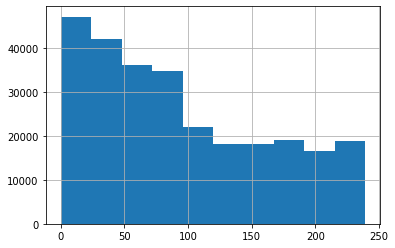

In [178]:
for_sensors.reset_index().T_ITSSensorNum.hist()

<AxesSubplot:>

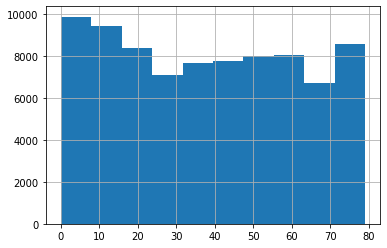

In [202]:
track_modules.reset_index().T_ITSModuleInner[track_modules.reset_index().T_ITSModuleInner >= 0].hist()

<AxesSubplot:>

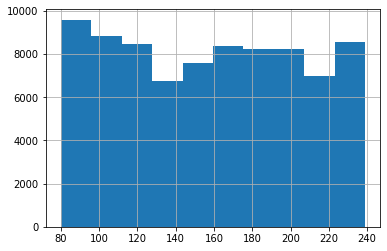

In [203]:
track_modules.reset_index().T_ITSModuleOuter[track_modules.reset_index().T_ITSModuleOuter >= 0].hist()